<a href="https://colab.research.google.com/github/tmiessa/mdc-defaultcredit/blob/development/mdc_defaultcredit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MDC 2019 - INF-0619 - Default of Credit Cards


## Alunos
* Matheus Pacheco
* Raphael Santos
* Renato Dias
* Tiago Miessa

## Imports

In [0]:
import sys
import os 
import requests
from datetime import date

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.utils import resample


from xgboost import XGBClassifier

In [0]:
sns.set_style("whitegrid")

## Download do Dataset

In [3]:
## download files
if os.path.isfile('UCI_Credit_Card.csv'):
    print('file already exists!')
else:
    print('file does not exists, downloading...')
    myfile = requests.get('https://onedrive.live.com/download?cid=F1E435813B40678A&resid=F1E435813B40678A%218086&authkey=AE0BdkzcP5BTU-M')
    open('UCI_Credit_Card.csv', 'wb').write(myfile.content)
    print('file downloaded')

file already exists!


In [0]:
df = pd.read_csv('UCI_Credit_Card.csv')

# Rename de coluna fora do padrão e do target, para facilitar referência futura
df.rename(columns={'PAY_0':'PAY_1','default.payment.next.month':'DEFAULTED'}, inplace=True)

In [5]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULTED
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## Análise Exploratória Inicial

### Verificação de Consistência das Features

In [6]:
df[['LIMIT_BAL', 'AGE']].describe()

,LIMIT_BAL,AGE
count,30000.000000,30000.000000
mean,167484.322667,35.485500
std,129747.661567,9.217904
min,10000.000000,21.000000
25%,50000.000000,28.000000
50%,140000.000000,34.000000
75%,240000.000000,41.000000
max,1000000.000000,79.000000


A feature `LIMIT_BAL`, que indica o limite de crédito do cartão, varia de 10.000 a 1.000.000 NT Dólares, e a idade varia de 21 a 79 anos.


In [7]:
df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100
std,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


In [8]:
df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].apply(pd.Series.value_counts).fillna(0).astype(int)

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
-2,2759,3782,4085,4348,4546,4895
-1,5686,6050,5938,5687,5539,5740
0,14737,15730,15764,16455,16947,16286
1,3688,28,4,2,0,0
2,2667,3927,3819,3159,2626,2766
3,322,326,240,180,178,184
4,76,99,76,69,84,49
5,26,25,21,35,17,13
6,11,12,23,5,4,19
7,9,20,27,58,58,46


**Features PAY_X**

As features `PAY_X` indicam o pagamento dos meses de Setembro de 2005 a Abril 2005, onde podem assumir os seguintes valores:

* **`-1:`** pago devidamente
* **`1:`** atraso no pagamento de 1 mês
* **`2:`** atraso no pagamento de 2 meses
* **`X:`** atraso no pagamento de X meses (limite superior = 9)

**Problemas encontrados:**

*   Valores -2 e 0, sem documentação





In [9]:
df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


**Features BILL_AMTX**

As features `BILL_AMTX` indicam o valor da fatura do cartão de crédito nos meses de Setembro 2005 (BILL_AMT1) a Abril 2005 (BILL_AMT6)

**Problemas encontrados:**

* Foram encontrados valores negativos em todos os meses.

In [10]:
df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [11]:
df[['SEX','EDUCATION', 'MARRIAGE']].describe()

,SEX,EDUCATION,MARRIAGE
count,30000.000000,30000.000000,30000.000000
mean,1.603733,1.853133,1.551867
std,0.489129,0.790349,0.521970
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000
max,2.000000,6.000000,3.000000


In [12]:
df[['SEX','EDUCATION', 'MARRIAGE']].apply(pd.Series.value_counts).fillna(0).astype(int)

,SEX,EDUCATION,MARRIAGE
0,0,14,54
1,11888,10585,13659
2,18112,14030,15964
3,0,4917,323
4,0,123,0
5,0,280,0
6,0,51,0


**Features SEX, EDUCATION e MARRIAGE**

* **`SEX:`** indica o gênero do cliente (1: masculino, 2: feminino)
* **`EDUCATION:`** nível de educação do cliente (1: graduate school, 2: university, 3: high school, 4: others, 5: desconhecido, 6: desconhecido)
* **`MARRIAGE:`** status marital (1: casado, 2: solteiro, 3: outros)

**Problemas Encontrados:**

* Valores não documentados para **`EDUCATION`** (0, 5, e 6)
* Valores não documentados para **`MARRIAGE`** (0)

### Pivotamento (para análise futura)

Para facilitar a análise de evolução no tempo das colunas PAY_N, BILL_AMTN e PAY_AMTN, definimos o método abaixo para fazer o pivotamento das informações:

In [0]:
def pivotAgg(row1):
    res = np.concatenate( ( 
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1','BILL_AMT1','PAY_AMT1','DEFAULTED']].append(pd.Series({'DATE':date(2005,9,1)}))],
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_2','BILL_AMT2','PAY_AMT2','DEFAULTED']].append(pd.Series({'DATE':date(2005,8,1)}))],
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_3','BILL_AMT3','PAY_AMT3','DEFAULTED']].append(pd.Series({'DATE':date(2005,7,1)}))],
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_4','BILL_AMT4','PAY_AMT4','DEFAULTED']].append(pd.Series({'DATE':date(2005,6,1)}))],
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_5','BILL_AMT5','PAY_AMT5','DEFAULTED']].append(pd.Series({'DATE':date(2005,5,1)}))],
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_6','BILL_AMT6','PAY_AMT6','DEFAULTED']].append(pd.Series({'DATE':date(2005,4,1)}))]
    ))
    return res

# Outra ideia a ser explorada: usar o melt para cada coluna alvo, ao invés de todas de uma vez (value_vars not set: everything else)
# test = df.melt(id_vars=['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE'])
# test.reset_index(drop=True,inplace=True)
# test.head()

In [0]:
pdf = pd.DataFrame(np.concatenate([ pivotAgg(row[1]) for row in df.iterrows()]))
pdf.columns = ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAYMENT STATUS','BILL AMOUNT','PAID AMOUNT','DEFAULTED', 'DATE']
pdf.to_csv('UCI_Credit_Card_Pivoted.csv', index=False)

Um ponto interessante é que o banco recebe muito menos do que o devido, com cerca de 11%:

In [0]:
pdf['PAID AMOUNT'].sum()/pdf['BILL AMOUNT'].sum()

0.11728746963554218

### Investigação da Distribuição dos Dados

Podemos observar que há um desbalanceamento entre as duas classes:

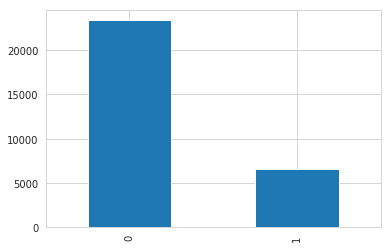

In [14]:
df['DEFAULTED'].value_counts().plot(kind='bar');

## Construção do Baseline

Serão construídos dois modelos, para verificação da acurácia antes que qualquer pré-processamento (com exceção de normalização) seja feito nos dados. O motivo para isso é que o problema pode estar na descrição, ao invés de no conjunto.



In [0]:
test_size_split = 0.2
random_seed_val = 42444

In [0]:
paymentFields = ['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
ownedFields = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']

# Campo ID será ignorado, por ser chave única
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:-1],df.iloc[:,-1], test_size=test_size_split, random_state=random_seed_val )

scaler = StandardScaler()

z_train = scaler.fit_transform(x_train)
z_test = scaler.transform(x_test)

In [9]:
%%time

encoder2D = TSNE()
w_train = encoder2D.fit_transform(z_train)
w_test = encoder2D.fit_transform(z_test)

CPU times: user 5min 21s, sys: 1.05 s, total: 5min 22s
Wall time: 5min 22s


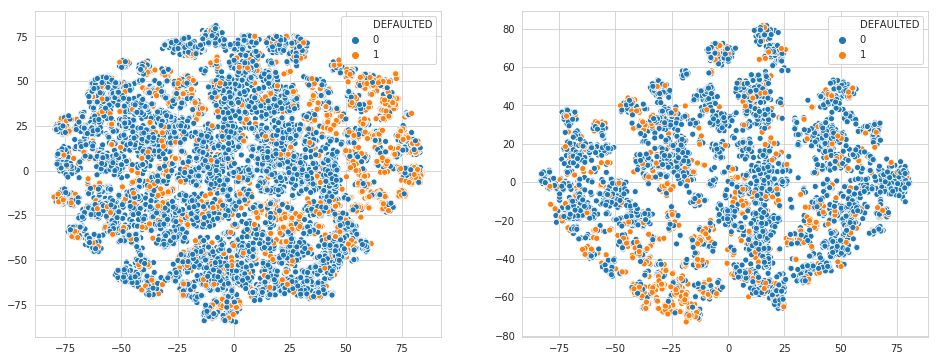

In [10]:
plt.figure(figsize=(16, 6))
categorical_colors = sns.color_palette(n_colors=2)

for ix, (x, y) in enumerate(((w_train, y_train), (w_test, y_test))):
    plt.subplot(1, 2, ix + 1)
    sns.scatterplot(*x.T, hue=y, palette=categorical_colors);

In [0]:
# sns.pairplot(df.iloc[:,1:],
#             hue='DEFAULTED',
#             diag_kind='hist',
#             vars=df.columns.values[1:]
# );


### Regressão Logística

In [20]:
## split train and test set
y = df['DEFAULTED'].values
x = df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].values
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, stratify=y, random_state=42)


print('different values of y: %s' % np.unique(y))

print('y_train distribution - label0: %d / label1: %d' % (len(y_train)-sum(y_train), sum(y_train)))
print('y_test distribution - label0: %d / label1: %d' % (len(y_test)-sum(y_test), sum(y_test)))


different values of y: [0 1]
y_train distribution - label0: 18722 / label1: 5278
y_test distribution - label0: 4642 / label1: 1358


In [0]:
## downsampling class 0
#tmp_nopay = np.column_stack((x_train[y_train==0], y_train[y_train==0]))
#tmp_pay = np.column_stack((x_train[y_train==1], y_train[y_train==1]))

In [0]:
#tmp_nopay = resample(tmp_nopay, replace=False, n_samples=len(y_train[y_train==1]), random_state=42)
#tmp_downsampled = np.concatenate([tmp_nopay, tmp_pay])

In [0]:
#x_train_resampled = tmp_downsampled[:,:-1]
#y_train_resampled = tmp_downsampled[:,-1:]

Logistic Regression
Accuracy: 68.23%
F1 Score: 47.32%
Balanced Accuracy: 66.39%


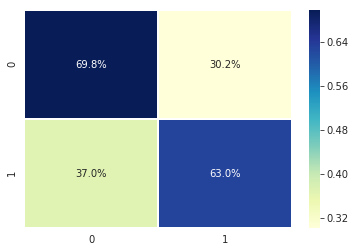

In [24]:
## logistic regression
# logreg = LogisticRegression(random_state=42, class_weight='balanced').fit(x_train, y_train)
# y_pred = logreg.predict(x_test)
logreg = LogisticRegression(random_state=42, solver = 'lbfgs', class_weight='balanced').fit(z_train, y_train)
y_pred = logreg.predict(z_test)
cm = confusion_matrix(y_test, y_pred)

print('Logistic Regression')
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred)*100))
print('F1 Score: %.2f%%' % (f1_score(y_test, y_pred)*100))
print('Balanced Accuracy: %.2f%%' % (balanced_accuracy_score(y_test, y_pred)*100))

sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito

r = cm/cm.sum(axis=1)[:,np.newaxis]
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

### SVM

In [25]:
svm = SVC(kernel='rbf', C=1, class_weight='balanced', random_state=999)
svm.fit(z_train, y_train)

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=999,
    shrinking=True, tol=0.001, verbose=False)

SVM - SVC
Accuracy: 77.23%
F1 Score: 53.60%
Balanced Accuracy: 70.47%


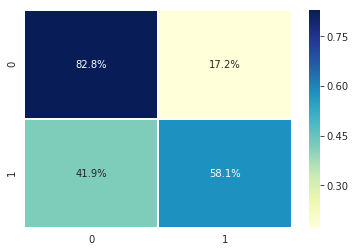

In [26]:
predictions = svm.predict(z_test)

print('SVM - SVC')
print('Accuracy: %.2f%%' % (accuracy_score(y_test, predictions)*100))
print('F1 Score: %.2f%%' % (f1_score(y_test, predictions)*100))
print('Balanced Accuracy: %.2f%%' % (balanced_accuracy_score(y_test, predictions)*100))

c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

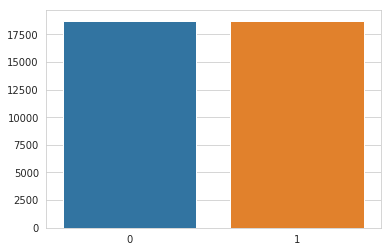

In [27]:
# Dados estão desbalanceados - usar um SMOTE ajudaria?
# Para o SVM provavelmente não, por conta de toda a ideia por trás dele. Mas checaremos de qualquer maneira, para ter certeza

smoter = SMOTE(sampling_strategy = 'minority', random_state=777)
sz_train, sy_train = smoter.fit_resample(z_train, y_train)

defaultedS = np.unique(sy_train, return_counts=True)
sns.barplot(defaultedS[0],defaultedS[1])

In [28]:
svmS = SVC(kernel='rbf', C=1, gamma='auto', random_state=999)
svmS.fit(sz_train, sy_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=999, shrinking=True, tol=0.001,
    verbose=False)

SVM - SVC SMOTED
Accuracy: 77.05%
F1 Score: 53.05%
Balanced Accuracy: 70.06%


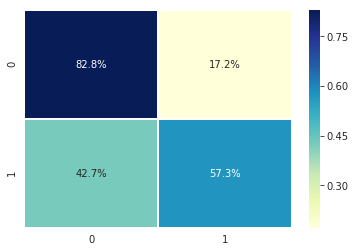

In [29]:
predictions = svmS.predict(z_test)

print('SVM - SVC SMOTED')
print('Accuracy: %.2f%%' % (accuracy_score(y_test, predictions)*100))
print('F1 Score: %.2f%%' % (f1_score(y_test, predictions)*100))
print('Balanced Accuracy: %.2f%%' % (balanced_accuracy_score(y_test, predictions)*100))

c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

### MLP

In [80]:
from sklearn.utils import class_weight

bcw = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict(enumerate(bcw))
class_weights

{0: 0.6409571626962931, 1: 2.2735884804850324}

In [106]:
from keras import models
from keras import layers
from keras import regularizers

penalty=1

model = models.Sequential()
model.add(layers.Dense(12, activation='relu', kernel_regularizer=regularizers.l2(penalty), input_shape=(z_train.shape[1],)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# model.add(layers.Dense(32, activation='sigmoid' , kernel_regularizer=regularizers.l2(penalty) ))
# model.add(layers.Dropout(0.5))

model.add(layers.Dense(6, activation='relu' , kernel_regularizer=regularizers.l2(penalty) ))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))
#model.compile(optimizer='sgd', loss='mse', metrics=['binary_accuracy'])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 12)                288       
_________________________________________________________________
batch_normalization_5 (Batch (None, 12)                48        
_________________________________________________________________
dense_68 (Dense)             (None, 12)                156       
_________________________________________________________________
batch_normalization_6 (Batch (None, 12)                48        
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 13        
Total params: 553
Trainable params: 505
Non-trainable params: 48
_________________________________________________________________


In [109]:
%%time

model.fit(z_train, y_train, batch_size = 32, epochs=20, class_weight=class_weights)

Epoch 1/20
24000/24000 [==============================] - 4s 187us/step - loss: 0.7681 - binary_accuracy: 0.7395
Epoch 2/20
24000/24000 [==============================] - 4s 186us/step - loss: 0.7250 - binary_accuracy: 0.7309
Epoch 3/20
24000/24000 [==============================] - 4s 184us/step - loss: 0.7654 - binary_accuracy: 0.7352
Epoch 4/20
24000/24000 [==============================] - 5s 188us/step - loss: 0.7426 - binary_accuracy: 0.7514
Epoch 5/20
24000/24000 [==============================] - 5s 189us/step - loss: 0.7105 - binary_accuracy: 0.7490
Epoch 6/20
24000/24000 [==============================] - 5s 193us/step - loss: 0.7116 - binary_accuracy: 0.7421
Epoch 7/20
24000/24000 [==============================] - 5s 197us/step - loss: 0.7185 - binary_accuracy: 0.7436
Epoch 8/20
24000/24000 [==============================] - 4s 186us/step - loss: 0.6760 - binary_accuracy: 0.7447
Epoch 9/20
24000/24000 [==============================] - 4s 183us/step - loss: 0.6999 - binary_

MLP básica
Accuracy: 22.70%
F1 Score: 36.92%
Balanced Accuracy: 50.02%


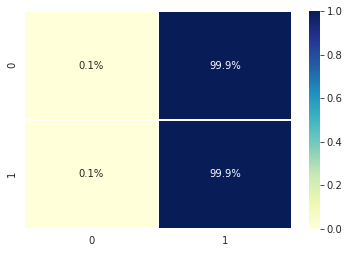

In [110]:
predictions = model.predict_classes(x_test)

print('MLP básica')
print('Accuracy: %.2f%%' % (accuracy_score(y_test, predictions)*100))
print('F1 Score: %.2f%%' % (f1_score(y_test, predictions)*100))
print('Balanced Accuracy: %.2f%%' % (balanced_accuracy_score(y_test, predictions)*100))

c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

## Análise Aprofundada dos Dados

### Feature Selection

 - Análise de correlação
 - Análise de importância para um classificador do algoritmo GBM

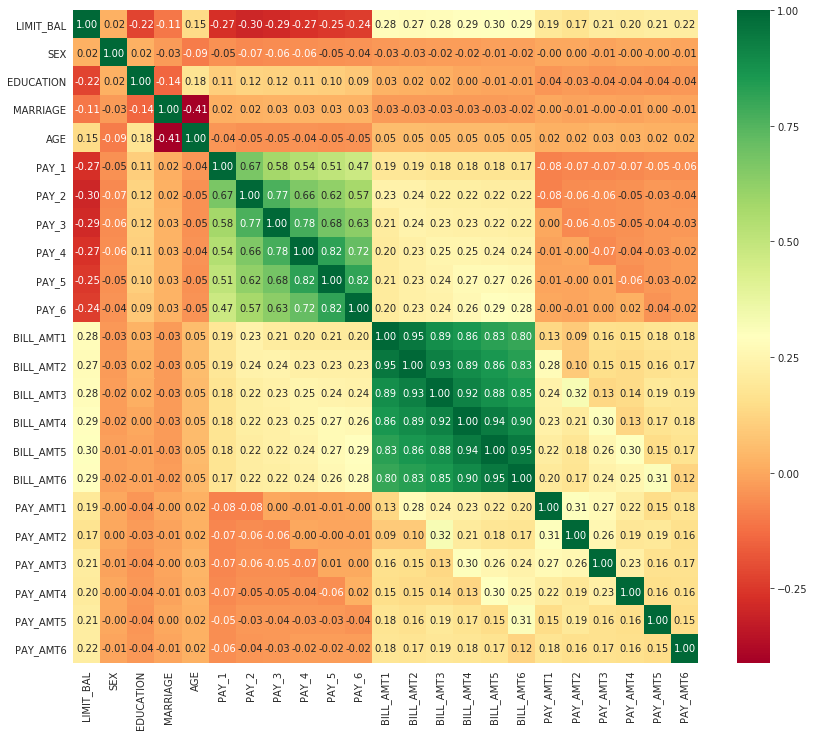

In [30]:
#get correlations of each features in dataset
corrmat = x_train.corr()
top_corr_features = corrmat.index
#plot heat map
plt.figure(figsize=(14,12))
g=sns.heatmap(x_train[top_corr_features].corr(), annot=True, cmap="RdYlGn", fmt='.2f')

In [31]:
gbm = GradientBoostingClassifier()
gbm.fit(sz_train, sy_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GBM - Baseline
Accuracy: 79.45%
F1 Score: 52.85%
Balanced Accuracy: 69.35%


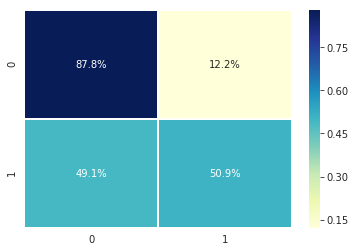

In [32]:
predictions = gbm.predict(z_test)

print('GBM - Baseline')
print('Accuracy: %.2f%%' % (accuracy_score(y_test, predictions)*100))
print('F1 Score: %.2f%%' % (f1_score(y_test, predictions)*100))
print('Balanced Accuracy: %.2f%%' % (balanced_accuracy_score(y_test, predictions)*100))

c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

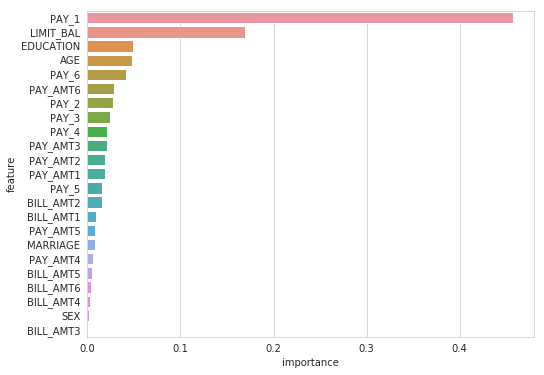

In [33]:
feature_importances = pd.DataFrame({ 'feature': x_train.columns, 'importance': gbm.feature_importances_})
feature_importances.sort_values('importance', ascending=False, inplace=True)

plt.figure(figsize=(8,6))
sns.barplot(feature_importances.importance,feature_importances.feature)


Considerações:
- As features referentes ao total das contas possuem alta correlação entre si, mas para o classificador GBM não foram especiamente relevantes
- Selecionamos com base nas features mais relevantes um subconjunto, para treinar um novo classificador SVM e comparar o resultado (sem utilizar SMOTE, já que não houve diferença significativa no teste anterior)

In [0]:
fx_train = x_train.loc[:,['EDUCATION','AGE','LIMIT_BAL','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','PAY_AMT1']]
fx_test = x_test.loc[:,['EDUCATION','AGE','LIMIT_BAL','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','PAY_AMT1']]

scaler2 = StandardScaler()

fz_train = scaler2.fit_transform(fx_train)
fz_test = scaler2.transform(fx_test)

SVM - SVC Redux
Accuracy: 77.08%
F1 Score: 54.12%
Balanced Accuracy: 70.94%


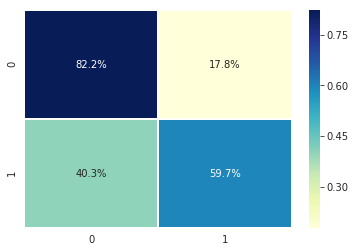

In [35]:
svm2 = SVC(kernel='rbf', C=1, class_weight='balanced', random_state=979979)
svm2.fit(fz_train, y_train)

predictions = svm2.predict(fz_test)

print('SVM - SVC Redux')
print('Accuracy: %.2f%%' % (accuracy_score(y_test, predictions)*100))
print('F1 Score: %.2f%%' % (f1_score(y_test, predictions)*100))
print('Balanced Accuracy: %.2f%%' % (balanced_accuracy_score(y_test, predictions)*100))

c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

### Limpeza dos dados

#### **Features BILL_AMTX**

**Problemas encontrados:**

* Foram encontrados valores negativos em todos os meses.


In [36]:

df[(df.BILL_AMT1 < 0) & (df.BILL_AMT2 <0)].head(5)[ ['ID'] + paymentFields + ownedFields]

,ID,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
26,27,0.0,1000.0,0.0,500.0,0.0,1000.0,-109.0,-425.0,259.0,-57.0,127.0,-189.0
68,69,0.0,0.0,20161.0,0.0,7319.0,13899.0,-190.0,-9850.0,-9850.0,10311.0,10161.0,7319.0
101,102,223.0,33178.0,1171.0,1197.0,1250.0,5000.0,-81.0,-303.0,32475.0,32891.0,33564.0,34056.0
109,110,0.0,0.0,0.0,0.0,0.0,0.0,-103.0,-103.0,-103.0,-103.0,-103.0,-103.0
149,150,0.0,22500.0,0.0,969.0,1000.0,0.0,-1100.0,-1100.0,21400.0,0.0,969.0,869.0



Esses valores fazem sentido em um contexto onde o cliente pagou mais do que deveria em um mês.  Dessa forma, não faremos nenhuma alteração nesta _Feature_

#### Feature EDUCATION

* **`EDUCATION:`** nível de educação do cliente (1: graduate school, 2: university, 3: high school, 4: others, 5: desconhecido, 6: desconhecido)

**Problemas Encontrados:**

* Valores não documentados para **`EDUCATION`** (0, 5, e 6)


In [37]:
df.EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

É possível que haja um problema na descrição do Dataset, mas como temos um valor "Others", iremos testar trocar os valores desconhecidos por ele.

In [0]:
# edu_x_train = x_train.copy()
# edu_x_test = x_test.copy()

x_train.EDUCATION[x_train.EDUCATION.isin([0,5,6])] = 4
x_test.EDUCATION[x_test.EDUCATION.isin([0,5,6])] = 4

edu_scaler = StandardScaler()
z_train = scaler.fit_transform(x_train)
z_test = scaler.transform(x_test)


In [0]:
svmEdu = SVC(kernel='rbf', C=1, class_weight='balanced', random_state=999)
svmEdu.fit(z_train, y_train)

predictions = svmEdu.predict(z_test)

SVM - Ajuste EDUCATION
Accuracy: 77.27%
F1 Score: 53.67%
Balanced Accuracy: 70.51%


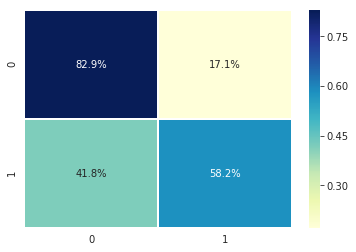

In [40]:
print('SVM - Ajuste EDUCATION')
print('Accuracy: %.2f%%' % (accuracy_score(y_test, predictions)*100))
print('F1 Score: %.2f%%' % (f1_score(y_test, predictions)*100))
print('Balanced Accuracy: %.2f%%' % (balanced_accuracy_score(y_test, predictions)*100))


c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

Essa mudança não afetou muito o SVM, mas afetou o GBM. Ver com o Rafael depois o que é melhor, deixar algo que não bata muito com a descrição mas que ajude a predição para algum algoritmo específico, ou deixar o dataset mais coerente com o esperado.

#### Feature MARRIAGE

* **`MARRIAGE:`** status marital (1: casado, 2: solteiro, 3: outros)

**Problemas Encontrados:**

* Valores não documentados para **`MARRIAGE`** (0)

In [41]:
df.MARRIAGE.value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [0]:
# mar_x_train = edu_x_train.copy()
# mar_x_test = edu_x_test.copy()

x_train.EDUCATION[x_train.EDUCATION.isin([0])] = 3
x_test.EDUCATION[x_test.EDUCATION.isin([0])] = 3

mar_scaler = StandardScaler()
z_train = scaler.fit_transform(x_train)
z_test = scaler.transform(x_test)


In [0]:
svmMAR = SVC(kernel='rbf', C=1, class_weight='balanced', random_state=999)
svmMAR.fit(z_train, y_train)
predictions = svmMAR.predict(z_test)

SVM - Ajuste MARRIAGE
Accuracy: 77.27%
F1 Score: 53.67%
Balanced Accuracy: 70.51%


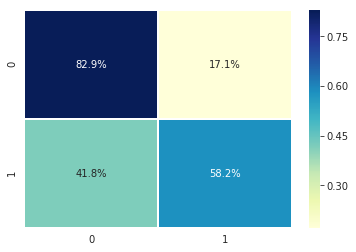

In [44]:
print('SVM - Ajuste MARRIAGE')
print('Accuracy: %.2f%%' % (accuracy_score(y_test, predictions)*100))
print('F1 Score: %.2f%%' % (f1_score(y_test, predictions)*100))
print('Balanced Accuracy: %.2f%%' % (balanced_accuracy_score(y_test, predictions)*100))

c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

Para a feature Marriage, a alteração dos valores não teve efeito notável. Dessa forma, iremos manter a alteração para deixar o Dataset mais próximo dos valores esperados de acordo com a descrição.

### Feature Engineering

Um detalhe que pode ser interessante para ajudar na predição é a porcentagem de quanto foi pago sobre o que era devido. Iremos adicionar essa feature e testar o resultado.

Iremos utilizar os valores corrigidos no passo anterior, uma vez que não houve mudança significativa nos indicadores analisados.


In [0]:
# x_train = mar_x_train
# x_test = mar_x_test

# Somando +1 para evitar campos com zero
x_train.insert(1,'PPAID', ((x_train[paymentFields].sum(axis=1)+1) / (x_train[ownedFields].sum(axis=1)+1)) )
x_test.insert(1,'PPAID', ((x_test[paymentFields].sum(axis=1)+1) / (x_test[ownedFields].sum(axis=1)+1)) )

scalerPP = StandardScaler()
z_train = scalerPP.fit_transform(x_train)
z_test = scalerPP.transform(x_test)


# df.insert(1,'PPAID', ((df[paymentFields].sum(axis=1)+1) / (df[ownedFields].sum(axis=1)+1)) )
# df.head(5)

SVM - Adição % pagamento
Accuracy: 77.28%
F1 Score: 53.66%
Balanced Accuracy: 70.50%


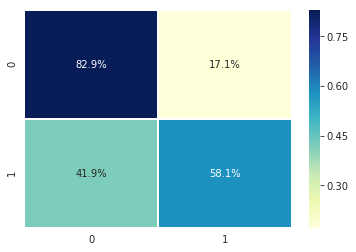

In [46]:
svmPP = SVC(kernel='rbf', C=1, class_weight='balanced', random_state=999)
svmPP.fit(z_train, y_train)
predictions = svmPP.predict(z_test)

print('SVM - Adição % pagamento')
print('Accuracy: %.2f%%' % (accuracy_score(y_test, predictions)*100))
print('F1 Score: %.2f%%' % (f1_score(y_test, predictions)*100))
print('Balanced Accuracy: %.2f%%' % (balanced_accuracy_score(y_test, predictions)*100))

c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

In [0]:
smoterPP = SMOTE(sampling_strategy = 'minority', random_state=777)
sz_train, sy_train = smoterPP.fit_resample(z_train, y_train)

GBM - Adição % pagamento
Accuracy: 79.50%
F1 Score: 52.91%
Balanced Accuracy: 69.38%


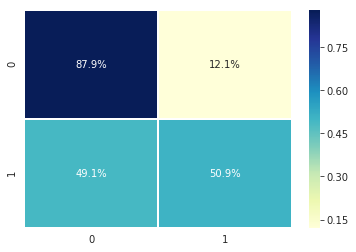

In [48]:
gbmPP = GradientBoostingClassifier()
gbmPP.fit(sz_train, sy_train)
predictions = gbmPP.predict(z_test)


print('GBM - Adição % pagamento')
print('Accuracy: %.2f%%' % (accuracy_score(y_test, predictions)*100))
print('F1 Score: %.2f%%' % (f1_score(y_test, predictions)*100))
print('Balanced Accuracy: %.2f%%' % (balanced_accuracy_score(y_test, predictions)*100))

c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

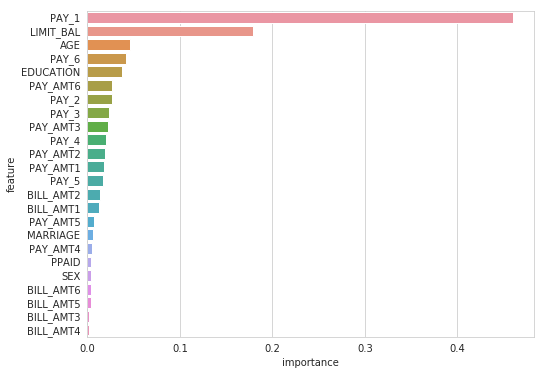

In [49]:
feature_importances = pd.DataFrame({ 'feature': x_train.columns, 'importance': gbmPP.feature_importances_})
feature_importances.sort_values('importance', ascending=False, inplace=True)

plt.figure(figsize=(8,6))
sns.barplot(feature_importances.importance,feature_importances.feature)

Essa feature não fez diferença alguma, irei tentar adicionar a média por mês apenas para teste

In [0]:
x_train.drop('PPAID', axis=1, inplace=True)
x_test.drop('PPAID', axis=1, inplace=True)

In [0]:

for i in range(1,7):
    x_train.insert(1, 'BTEMP'+str(i), x_train['BILL_AMT'+str(i)])
    x_test.insert(1, 'BTEMP'+str(i), x_test['BILL_AMT'+str(i)])
    
    x_train.insert(1, 'PTEMP'+str(i), x_train['PAY_AMT'+str(i)])
    x_test.insert(1, 'PTEMP'+str(i), x_test['PAY_AMT'+str(i)])
    
    # Onde o total é 0, consideraremos 100% pago a dívida do mês
    x_train['PTEMP'+str(i)][x_train['BILL_AMT'+str(i)] == 0] = 1
    x_train['BTEMP'+str(i)][x_train['BILL_AMT'+str(i)] == 0] = 1
    
    x_test['PTEMP'+str(i)][x_test['BILL_AMT'+str(i)] == 0] = 1
    x_test['BTEMP'+str(i)][x_test['BILL_AMT'+str(i)] == 0] = 1
    
    x_train.insert(1,'PPAID'+str(i), x_train['PTEMP'+str(i)] / x_train['BTEMP'+str(i)] )
    x_test.insert(1,'PPAID'+str(i), x_test['PTEMP'+str(i)] / x_test['BTEMP'+str(i)] )

In [101]:
# checagem de valores nulos
x_train.loc[x_train.index[np.isinf(x_train).any(1)]].head(5)

,LIMIT_BAL,PPAID6,PTEMP6,BTEMP6,PPAID5,PTEMP5,BTEMP5,PPAID4,PTEMP4,BTEMP4,PPAID3,PTEMP3,BTEMP3,PPAID2,PTEMP2,BTEMP2,PPAID1,PTEMP1,BTEMP1,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6


In [0]:
for i in range(1,7):
    x_train.drop('BTEMP'+str(i), axis=1, inplace=True)
    x_train.drop('PTEMP'+str(i), axis=1, inplace=True)
    x_test.drop('BTEMP'+str(i), axis=1, inplace=True)
    x_test.drop('PTEMP'+str(i), axis=1, inplace=True)

In [0]:
scalerMP = StandardScaler()

mz_train = scalerMP.fit_transform(x_train)
mz_test = scalerMP.transform(x_test)

In [0]:
smoterMPP = SMOTE(sampling_strategy = 'minority', random_state=777)
sz_train, sy_train = smoterMPP.fit_resample(mz_train, y_train)

GBM - média pagamento por cada mês
Accuracy: 79.33%
F1 Score: 53.66%
Balanced Accuracy: 69.97%


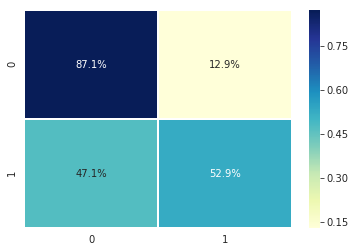

In [108]:
gbmMPP = GradientBoostingClassifier()
gbmMPP.fit(sz_train, sy_train)
predictions = gbmMPP.predict(mz_test)


print('GBM - média pagamento por cada mês')
print('Accuracy: %.2f%%' % (accuracy_score(y_test, predictions)*100))
print('F1 Score: %.2f%%' % (f1_score(y_test, predictions)*100))
print('Balanced Accuracy: %.2f%%' % (balanced_accuracy_score(y_test, predictions)*100))

c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

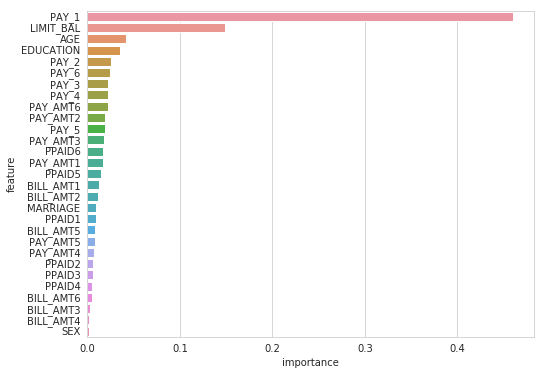

In [110]:
feature_importances = pd.DataFrame({ 'feature': x_train.columns, 'importance': gbmMPP.feature_importances_})
feature_importances.sort_values('importance', ascending=False, inplace=True)

plt.figure(figsize=(8,6))
sns.barplot(feature_importances.importance,feature_importances.feature)

Yep.... gigante pilha de .... nada. Remoção das features inúteis

In [0]:
for i in range(1,7):
    x_train.drop('PPAID'+str(i), axis=1, inplace=True)
    x_test.drop('PPAID'+str(i), axis=1, inplace=True)
    

In [113]:
x_train.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
25806,150000.0,2,2,2,30,0,0,0,0,0,0,69955.0,59380.0,57431.0,52754.0,52430.0,41770.0,1873.0,1897.0,1552.0,1649.0,2005.0,11064.0
18204,260000.0,1,1,2,39,0,0,0,0,0,0,248880.0,248758.0,245404.0,169632.0,165098.0,151157.0,10611.0,9708.0,5929.0,5622.0,5465.0,5474.0
4139,220000.0,1,1,2,48,0,0,0,2,0,0,115294.0,117945.0,130365.0,126780.0,129570.0,133553.0,6000.0,16000.0,0.0,5000.0,6300.0,3000.0
18540,60000.0,2,2,2,24,0,0,0,0,0,0,29832.0,18628.0,15069.0,15761.0,5879.0,-2879.0,1538.0,1308.0,1000.0,118.0,1329.0,41378.0
6443,110000.0,2,2,2,32,0,0,0,0,0,0,108159.0,106812.0,108464.0,108829.0,110557.0,106082.0,5400.0,5400.0,4100.0,4100.0,4100.0,4200.0


## OneHotEncoding das Features categóricas

As features 'SEX', 'EDUCATION', 'MARRIAGE','PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5' e 'PAY_6' possuem valores discretos e podem auxiliar o classificador caso sejam codificadas de forma categórica.

In [0]:
encoder = ColumnTransformer([
    ('num', StandardScaler(), ['LIMIT_BAL', 'AGE']+ ownedFields + paymentFields),
    ('cat', OneHotEncoder(categories='auto',sparse=False,), ['SEX', 'EDUCATION', 'MARRIAGE','PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])
]) #, sparse_threshold = 0

e_train = encoder.fit_transform(x_train)
e_test  = encoder.transform(x_test)

SVM - OHE Features categóricas
Accuracy: 77.78%
F1 Score: 53.01%
Balanced Accuracy: 69.86%


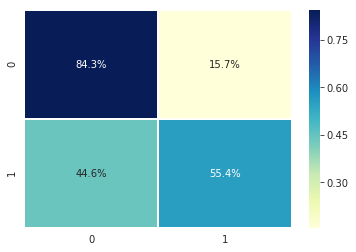

In [18]:
svmOHE = SVC(kernel='rbf', C=1, gamma='auto', class_weight='balanced', random_state=999)
svmOHE.fit(e_train, y_train)
predictions = svmOHE.predict(e_test)


print('SVM - OHE Features categóricas')
print('Accuracy: %.2f%%' % (accuracy_score(y_test, predictions)*100))
print('F1 Score: %.2f%%' % (f1_score(y_test, predictions)*100))
print('Balanced Accuracy: %.2f%%' % (balanced_accuracy_score(y_test, predictions)*100))

c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

Não enxergamos diferença significativa após processar as colunas categóricas com OHE.

## Teste do classificador XGB

In [121]:
%%time

model = XGBClassifier()
model.fit(x_train, y_train)

predictions = model.predict(x_test)

CPU times: user 2.32 s, sys: 6.96 ms, total: 2.33 s
Wall time: 2.33 s


XGBoost - No SMOTE
Accuracy: 81.72%
F1 Score: 47.49%
Balanced Accuracy: 65.73%


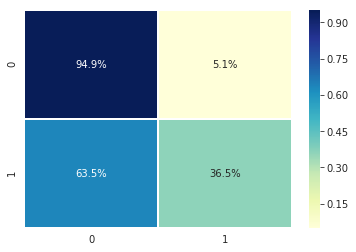

In [123]:
print('XGBoost - No SMOTE')
print('Accuracy: %.2f%%' % (accuracy_score(y_test, predictions)*100))
print('F1 Score: %.2f%%' % (f1_score(y_test, predictions)*100))
print('Balanced Accuracy: %.2f%%' % (balanced_accuracy_score(y_test, predictions)*100))


c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

In [129]:
x_test.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
812,140000.0,2,1,2,24,1,-2,-2,-2,-1,-1,0.0,0.0,0.0,0.0,1086.0,0.0,0.0,0.0,0.0,1086.0,0.0,0.0
6126,490000.0,1,1,1,29,-1,-1,-1,-1,0,-1,115.0,109.0,1375.0,230.0,115.0,113.0,109.0,1381.0,230.0,0.0,113.0,0.0
26447,340000.0,2,2,1,48,0,0,0,0,0,0,310866.0,320685.0,320614.0,21768.0,22405.0,24545.0,15000.0,7000.0,1500.0,1000.0,2500.0,112500.0
20629,220000.0,1,1,2,29,0,0,0,0,0,0,26012.0,25916.0,24998.0,23965.0,23865.0,23667.0,1410.0,1417.0,1333.0,731.0,1019.0,1045.0
9976,110000.0,2,1,2,32,1,-1,0,0,0,-2,0.0,1670.0,11693.0,7903.0,-18.0,-18.0,1670.0,10200.0,0.0,0.0,0.0,0.0


In [0]:
smoterX = SMOTE(sampling_strategy = 'minority', random_state=71717)
sz_train, sy_train = smoterX.fit_resample(x_train, y_train)

modelS = XGBClassifier()
modelS.fit(sz_train, sy_train)

predictions = modelS.predict(x_test.values)

XGBoost - SMOTE-d
Accuracy: 81.67%
F1 Score: 48.41%
Balanced Accuracy: 66.22%


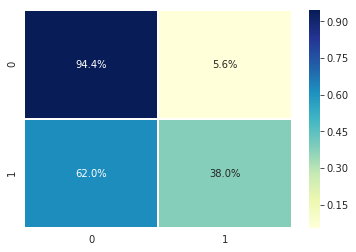

In [133]:
print('XGBoost - SMOTE-d')
print('Accuracy: %.2f%%' % (accuracy_score(y_test, predictions)*100))
print('F1 Score: %.2f%%' % (f1_score(y_test, predictions)*100))
print('Balanced Accuracy: %.2f%%' % (balanced_accuracy_score(y_test, predictions)*100))


c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:-1],df.iloc[:,-1], test_size=test_size_split, random_state=random_seed_val)

scaler = StandardScaler()
z_train = scaler.fit_transform(x_train)
z_test = scaler.transform(x_test)

params2Test = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1, 10], #auto equivale a 0.043
    'kernel': ['linear', 'rbf'],
    'class_weight': [None, 'balanced']
}


grid = GridSearchCV(SVC(), params2Test, scoring='balanced_accuracy', cv=5)

In [0]:
%%time

grid.fit(z_train, y_train)